<a href="https://colab.research.google.com/github/Seb125/MFCC_Genres/blob/main/Genres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass classification with kernalized SVM and MLP

## Music genre classification using mfcc's

In this notebook I want to classify music from 10 different genres. The input data is the GTZAN Dataset (https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification), which contains 100 30s exerpts for 10 diffenrent genres. For each exerpt mfcc vectors are calculated, which are used as input data for the machine learning algorithms. 

The mapping of the labels:
       0: "hiphop",
       1: "blues",
       2: "rock",
       3: "jazz",
       4: "disco",
       5: "metal",
       6:"classical",
       7: "pop",
       8: "country",
       9: "reggae"

## Theory on Kernel methods (https://bloom.bg/2ui2T4q)

### Motivation

Mapping from an input space $\chi$ to a vector in $R^d$ is called feature extraction.  
Feature mapping is a function of the form $\psi: \chi -> R^d$.  
To get expressive hypothesis spaces using linear models we need high-dimensional feature spaces. Suppose we start with $x= (1, x_1, ..., x_d) \in R^{d+1} = \chi$. Now with our feature mapping $\psi(x)$ we want all monomials of degree M. Then we will end up with the number of features of $O(d^M)$?. Thus we will get extremely large matrices. Having large feature spaces have two problems, Overfitting (handled by regularization) and memory, computational cost. Kernel methods can (sometimes) help with memory and computational costs.


###### Definition

A method can be kernalized if inputs appear inside inner products: $\langle  \; \psi(x), \psi(x') \; \rangle$ for $x, x' \in \chi$.  
The kernel function corresponding to such an inner product is:  

$k(x,x') = \langle  \; \psi(x), \psi(x') \; \rangle$.  

Kernels as similarity scores: It is often useful to think of the kernel function as a similarity score. The final classifier is a similarity-weighted vote (see section... for details). However this is not a mathematically precise statement.



###### Different Kernels

###### Linear Kernel

Feature map: $\phi(x)  = x$  
Kernel: $k(x, x') = x^Tx'$

A linear kernel uses just the original input features. The output of the linear kernel function just gives the standard dot product between two data points $x^Tx'$. As x and x' lie in the original input space,w e don't get acces to a higher dimensional feature space by using a lienar kernel. We are using the original feature space and the kernel function does not has any computational benefits. So if our input vector already lie in high dimensional feature space, such that the data is already seperable with a linear method, I won't get any benefit form using kernel methods.(?)

###### Quadratic Kernel

Input space $\chi = R^d$  
Feature space: $H = R^D$, where $D = d + \binom{d}{2} \approx \frac{d^2}{2}$.

Feature map: 

$\psi(x) = (x_1,...,x_d,x^2_1,...x^2_d,\sqrt{2}x_1x_2,...,\sqrt{2}x_{d-1}x_d)^T$

Then for $\forall x, x' \in R^d$

$k(x,x') = \langle  \; \psi(x), \psi(x') \; \rangle = \langle  \; x, x' \; \rangle + \langle  \; x, x' \; \rangle ^2$

Computation for inner product with explicit mapping: $O(d^2)$  
Computation for implicit kernel calculation: $O(d)$.

Thus with the qudratic kernel function we can evaluate a dot product of feature space that includes all monomials up to degree 2 of the original input space, while computation cost is in the same order as for the original feature space. Notice that we have these extra coefficients ($\sqrt{2}$) in front of our features. These interact with our regularization. We can use smaller coefficients $w$ to get the same output, such that with regularization these features get favored by the model.

###### Polynomial Kernel

Input space $\chi = R^d$  
Kernel function:  

$k(x,x') = (1 + \langle  \; x, x' \; \rangle)^M$
    
Corresponds to a feature map with all monomials up to degree M.  
For any M, computing the kernel has same computationsl cost.  
Cost of explicit inner product computation grows rapidly in M. 

###### RBF/Gaussian Kernel

Input space $\chi = R^d$   
Kernel function:  

$k(x,x') = exp(-\frac{||x-x'||^2}{2\sigma^2})$ 

where $\sigma^2$ is known as the bandwith parameter. 

Does it act like a similarity score?:
For $x=x'$ the kernel evaluates to 1 and for increasing distance between x and x' the value of the functions gets closer to 0.  
Why "radial"?: The output is independent of orientation. All x's in the same radius of x get the same similarity score.  
For the RBF kernel we have in some sense departed form our "inner product of feature vector" recipe. The RBF kernel corresponds to an infinite dimensional feature vector ($\psi(x)$ has infinite number of dimensions). 
It is probably the most common nonlinear kernel. 
How does the kernel function behave if we change $\sigma^2$?:....see UCSD lecture slides!

###### The Kernel trick

We can transform certain objektive functions into a kernalized version (see details below). This kernalized objective function contains the kernel matrix.

For points $x_1,...,x_n \in \chi$ and an inner product $\langle  \; .,. \; \rangle$ on $\chi$, the kernel matrix is defined as:  

$K = (\langle  \; x_i, x_j \; \rangle)_{ij} = \left(\begin{array}{rrr} 
\langle  \; x_1, x_1 \; \rangle & ... & \langle  \; x_1, x_n \; \rangle \\ 
... & ... & ... \\ 
\langle  \; x_n, x_1 \; \rangle & ... & \langle  \; x_n, x_n \; \rangle \\ 
\end{array}\right) = XX^T$  

which is an $nxn$ matrix. 

Given a kernalized ML algorithm, we can swap out the kernel function. The new kernel may correspond to a high dimensional feature space. Once the kernel matrix is computed , the computational cost depends only on the number of data points, rather than the dimesnion of the feature space. 

In ridge regression we deel with a matrix $X^TX$ which is $dxd$. In general you would prefer to work with the smaller matrix. Thus kernel methods are prefered when $n<<d$.

Swapping out a linear kernel for a new kernel is called the kernel trick.


### How to kernalize an objective function

#### Generalized objective function

Featurized SVM objective:

$min_{w\in R^d} \frac{1}{2} ||w||^2 + \frac{c}{n} \Sigma_{i=1}^{n} max(0, 1 - y_i[\langle  \; w, \psi(x_i) \; \rangle])$

Generalized objective:

$min_{w\in H}  R(||w||) + L(\langle  \; w, \psi(x_1) \; \rangle, .... , \langle  \; w, \psi(x_n) \; \rangle)$,

where

$R: R^{>=0} -> R$ in nondecreasing (Regularization term)  
$L: R^n -> R$ is arbitrary (Loss term)   
with Hilbert space $H$, typically $H = R^d$

Ridge regression and SVM are of this form.  
Lasso regression is not of this form, as $l_1$ does not correspond to an inner product (Why is this important? see section....).

#### Representer Theorem

Let $min_{w\in H}  R(||w||) + L(\langle  \; w, \psi(x_1) \; \rangle, .... , \langle  \; w, \psi(x_n) \; \rangle)$.

If J(w) has a minimizer, then it has a minimizer of the form $w^* = \Sigma_{i=1}^{n} \alpha_i \psi(x_i)$. Thus $w^*$ lies in the span of the data; is a linear combination of the featurized input vectors.

Proof

Let w be a minimizer  
Let $M = span(\langle  \; w, \psi(x_1) \; \rangle, .... , \langle  \; w, \psi(x_n) \; \rangle)$  
Let $w^*= Proj_M w$. So $\exists$ s.t. $w^* = \Sigma_{i=1}^{n} \alpha_i \psi(x_i)$  
$w^*$ lives in $R^d$ but it lives also in M, which is a subspace of $R^d$ of dimension n.  
$w^{\bot} := w - w^*$ is orthogonal to M.  
Projections decrease norms: $||w^*|| \leq ||w||$  
Since R is nondecreasing, $R(||w^*||) \leq R(||w||)$  

$\langle  \; w, \psi(x_i) \; \rangle = \langle  \; w^* + w - w^*, \psi(x_i) \; \rangle = \langle  \; w^* + w^{\bot}, \psi(x_i) \; \rangle = \langle  \; w^*, \psi(x_i) \; \rangle + \langle  \; w^{\bot}, \psi(x_i) \; \rangle
= \langle  \; w^*, \psi(x_i) \; \rangle$  

So $L(\langle  \; w, \psi(x_i) \; \rangle) = L(\langle  \; w^*, \psi(x_i) \; \rangle)$  

$J(w^*) \leq J(w)$

Therefore $w^* = \Sigma_{i=1}^{n} \alpha_i \psi(x_i)$ is also a minimizer.


#### Kernalized predictions

Consider $w^* = \Sigma_{i=1}^{n} \alpha_i \psi(x_i)$ (In he following w is used, but I refer to $w^*$ as described in the representer theorem).  

How do we make predictions for a given $x \in \chi$?  

$f(x) = \langle  \; w, \psi(x) \; \rangle = \langle  \; \Sigma_{i=1}^{n} \alpha_i \psi(x_i), \psi(x) \; \rangle = \Sigma_{i=1}^{n} \alpha_i \langle  \; \psi(x_i), \psi(x) \; \rangle = \Sigma_{i=1}^{n} \alpha_i k(x_ix)$

Predictions on training points $x_1$ to $x_n$:  

$ \left(\begin{array}{r} 
f(x_1) \\ 
... \\ 
f(x_n)\\ 
\end{array}\right) = \left(\begin{array}{r} 
\Sigma_{i=1}^{n} \alpha_i k(x_ix_1) \\ 
... \\ 
\Sigma_{i=1}^{n} \alpha_i k(x_ix_n)\\ 
\end{array}\right)= \left(\begin{array}{r} 
\alpha_1k(x_1x_1) + ... + \alpha_nk(x_1x_n) \\ 
... \\ 
\alpha_1k(x_nx_1) + ... + \alpha_nk(x_nx_n)\\ 
\end{array}\right) = \left(\begin{array}{r} 
k(x_1x_1) + ... + k(x_1x_n) \\ 
... \\ 
k(x_nx_1) + ... + k(x_nx_n)\\ 
\end{array}\right) \left(\begin{array}{r} 
\alpha_1\\ 
... \\ 
\alpha_n\\ 
\end{array}\right) = K\alpha$  

Note: f(x) is a linear combination of $k(x_1,x),...,k(x_n,x)$, all considered functions of x.  


#### Kernalized regularization

Consider $w = \Sigma_{i=1}^{n} \alpha_i \psi(x_i)$. What does $R(||w||)$ look like?  

$||w||^2 = \langle  \; w, w \; \rangle = \langle  \; \Sigma_{i=1}^{n} \alpha_i \psi(x_i), \Sigma_{i=1}^{n} \alpha_i \psi(x_i) \; \rangle = \Sigma_{i,j=1}^{n} \alpha_i \alpha_j \langle  \; \psi(x_i), \psi(x_j) \; \rangle = \Sigma_{i,j=1}^{n} \alpha_i \alpha_j k(x_i,x_j) = \alpha^TK\alpha$

This is a quadratic form.

#### Now we can kernalize some objective functions

##### Kernalize SVM

The SVM objective:  

$min_{w\in R^d} \frac{1}{2} ||w||^2 + \frac{c}{n} \Sigma_{i=1}^{n} max(0, 1 - y_i[\langle  \; w, \psi(x_i) \; \rangle])$

Kernelizing yields:

$min_{\alpha\in R^n} \frac{1}{2} \alpha^TK\alpha + \frac{c}{n} \Sigma_{i=1}^{n} max(0, 1 - y_i(K\alpha)_i)$

SVM work very nicely with kernalizations, as many $\alpha's$ are equal to 0. So not all n datapoints are needed for a prediction.

##### Kernalize Ridge Regression

Featurized ridge regression

$min_{w\in R^d} \frac{1}{n} \Sigma_{i=1}^{n} (\langle  \; w, \psi(x_i) \; \rangle - y_i)^2 + \lambda ||w||^2$

Kernalized ridge Regression:

$min_{\alpha\in R^n} \frac{1}{n} ||K\alpha - y||^2 + \lambda\alpha^TK\alpha$

## Extracting mfcc vectors from the soundfiles and saving them as json file

In [1]:
import os
import librosa
import math
import json

DATASET_PATH = "Genres"
JSON_PATH = "data.json"

SAMPLE_RATE = 22050
DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION


# json_path: path to the file where we store all mfccs and the labels
# each track is chopped into 10 segments

def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=10):
    
    # dictionary to store data
    data = {
      "mapping": [], # classical is mapped to indice 0
      "mfcc": [], # mfccs for each segment
      "labels":[]  # target (first segment is classical, second, classical....)

    }
    
    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)
    
    # loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # esnure that we're not at the root/dataset level
        if dirpath is not dataset_path:   #dirpath gives path of current directory
            
            # save the semantic label
            dirpath_components = dirpath.split("/") # genre/blues => ["genre", "blues"]
            semantic_label = dirpath_components[-1]  # last entry of dirpath_components
            data["mapping"].append(semantic_label)
            print("\nProcessing {}".format(semantic_label))

            # process files for a specific genre
            for f in filenames:
                
                #load audio file
                file_path = os.path.join(dirpath, f)
                print(file_path)
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                
                # process segments extracting mfcc and storing data
                for s in range(num_segments):
                    start_sample = num_samples_per_segment * s # s = 0 -> 0
                    finish_sample = start_sample + num_samples_per_segment # s = 0 -> num_samples_per_segment

          
                    mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                                      sr=sr,
                                                      n_fft=n_fft,
                                                      n_mfcc=n_mfcc,
                                                      hop_length=hop_length)
                    
                    mfcc = mfcc.T  # transpose -> mfcc vectors are columns
                    
                    
                    # store mfcc for segment if it has the expected length
                    if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1) # cause the first iteration is at the root level
                        print("{}, segment:{}".format(file_path, s))
   
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

## Loading json file containing mfcc vectors and genre labels

In [2]:
import json
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import svm, metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score


DATASET_PATH = "data10.json"  # Here I import a smaller version of the GTZAN Dataset with 10 songs per genre

def load_data(dataset_path):
    with open(dataset_path, "r") as fp: # r = read
        data = json.load(fp)
        
    # convert lists into numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])

    return inputs, targets


In [3]:
#load data
inputs, targets = load_data(DATASET_PATH)

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.3)

### Flattening and Normalizing Input vectors

In [4]:
from sklearn.preprocessing import StandardScaler

# Reshape inputs: Inputs have 3 dimensions (0:segments, 1:mfcc windows in each segment, 2:mff vectors)
# for each segment we concatenate all mfcc vectors

# inputs_train.shape = (699, 130, 13) inputs_train_reshaped.shape = (699, 1690)
X_train_reshaped = X_train.reshape(699,1690)
# inputs_train.shape = (300, 130, 13) inputs_train_reshaped.shape = (300, 1690)
X_test_reshaped = X_test.reshape(300,1690)

# normalizing input features
X_train = StandardScaler().fit_transform(X_train_reshaped)
X_test = StandardScaler().fit_transform(X_test_reshaped)


Input data:

In [5]:
X_train.shape

(699, 1690)

For each 10s segment we had 130 mfcc vectors. After flattening the data we get a 1690 dimensional vector for each of the 699 10s segments. As described above, kernalzing an objective function can give you access to high dimensional feature spaces. For a polynomail kernel of degree 3 for example, the featurized input vector is of order $O(d^3)$. For our 1690 dimensional feature vectors this results in a dimension of the order $10^9$. 
Overfitting should not be a problem as long as we use regularization. With such a large feature space we probably can generate a quite expressive model, while the computational cost is reduced by the kernalization, as the number of data points is comparatively very low (see above). SVM's can be kernalized. Also, as many $\alpha's$ are 0 (this can be seen by optimizing the dual objective of a SVM), such that not all n data points are needed for making predictions. Therefore SVM's with different kernels are used in the following to classify the songs into 10 different genres.

## SVM with different kernels (linear, poly, rbf)

Using 5 fold Cross Validation to tune C value of SVM

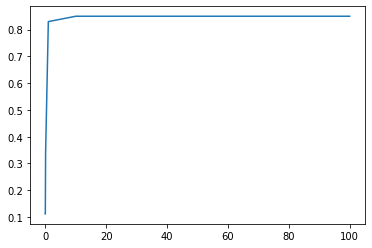

Choice of C:  10.0
Cross-validation accuracy score estimate:  0.8498343685300208


In [6]:
c_values = [0.001,0.01,0.1,1.0,10.0,100.0]

acc_scores_rbf = []
for c in c_values:
    
    clf = svm.SVC(C=c, kernel = 'rbf')
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    m = scores.mean()
    acc_scores_rbf.append(m)
    
index_max = max(range(len(acc_scores_rbf)), key=acc_scores_rbf.__getitem__) # get the index of hyperparameter with max accuracy 
    
plt.plot(c_values, acc_scores_rbf)
plt.show()
h, s = c_values[index_max], max(acc_scores_rbf)
print("Choice of C: ", h)
print("Cross-validation accuracy score estimate: ", s)

In [7]:
clf_rbf = svm.SVC(C=10, kernel = 'rbf')
clf_rbf.fit(X_train, y_train)
y_pred = clf_rbf.predict(X_train)
metrics.accuracy_score(y_train, y_pred)

1.0

In [8]:
y_pred_rbf = clf_rbf.predict(X_test)
metrics.accuracy_score(y_test, y_pred_rbf)

0.8466666666666667

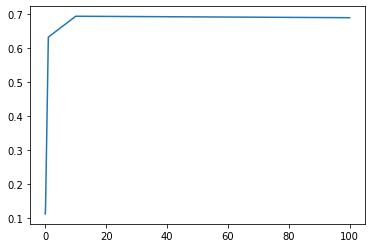

Choice of C:  10.0
Cross-validation accuracy score estimate:  0.6938540596094553


In [9]:
c_values = [0.001,0.01,0.1,1.0,10.0,100.0]

acc_scores_poly = []
for c in c_values:
    
    clf = svm.SVC(C=c, kernel = 'poly')
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    m = scores.mean()
    acc_scores_poly.append(m)
    
index_max = max(range(len(acc_scores_poly)), key=acc_scores_poly.__getitem__) # get the index of hyperparameter with max accuracy 
    
plt.plot(c_values, acc_scores_poly)
plt.show()
h, s = c_values[index_max], max(acc_scores_poly)
print("Choice of C: ", h)
print("Cross-validation accuracy score estimate: ", s)

In [10]:
clf_poly = svm.SVC(C=10, kernel = 'poly')
clf_poly.fit(X_train, y_train)
y_pred = clf_poly.predict(X_train)
metrics.accuracy_score(y_train, y_pred)

1.0

In [11]:
y_pred_poly = clf_poly.predict(X_test)
metrics.accuracy_score(y_test, y_pred_poly)

0.7233333333333334

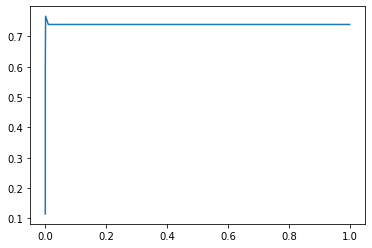

Choice of C:  0.001
Cross-validation accuracy score estimate:  0.7668036998972251


In [12]:
c_values = [0.00001,0.0001,0.001,0.01,0.1,1]

acc_scores_linear = []
for c in c_values:
    
    clf = svm.SVC(C=c, kernel = 'linear')
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    m = scores.mean()
    acc_scores_linear.append(m)
    
index_max = max(range(len(acc_scores_linear)), key=acc_scores_linear.__getitem__) # get the index of hyperparameter with max accuracy 
    
plt.plot(c_values, acc_scores_linear)
plt.show()
h, s = c_values[index_max], max(acc_scores_linear)
print("Choice of C: ", h)
print("Cross-validation accuracy score estimate: ", s)

In [13]:
clf_linear = svm.SVC(C=0.001, kernel = 'linear')
clf_linear.fit(X_train, y_train)
y_pred = clf_linear.predict(X_train)
metrics.accuracy_score(y_train, y_pred)

0.9728183118741058

In [14]:
y_pred_linear = clf_linear.predict(X_test)
metrics.accuracy_score(y_test, y_pred_linear)

0.7833333333333333

## Neural network (MLP)

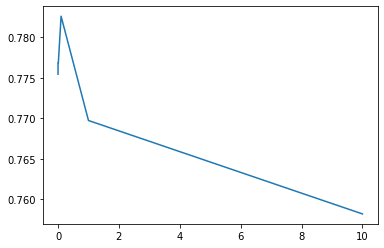

Choice of C:  0.1
Cross-validation accuracy score estimate:  0.7825899280575539


In [30]:
from sklearn.neural_network import MLPClassifier

c_values = [0.0001,0.001,0.01,0.1,1.0,10.0]

acc_scores_linear = []
for c in c_values:
    
    clf = MLPClassifier(solver='adam', alpha=c,
                 hidden_layer_sizes=(850),activation='relu', random_state=1, max_iter = 4000)
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    m = scores.mean()
    acc_scores_linear.append(m)
    
index_max = max(range(len(acc_scores_linear)), key=acc_scores_linear.__getitem__) # get the index of hyperparameter with max accuracy 
    
plt.plot(c_values, acc_scores_linear)
plt.show()
h, s = c_values[index_max], max(acc_scores_linear)
print("Choice of C: ", h)
print("Cross-validation accuracy score estimate: ", s)

In [31]:
from sklearn.neural_network import MLPClassifier

clf_mlp = MLPClassifier(solver='adam', alpha=0.1,
                 hidden_layer_sizes=(850),activation='relu', random_state=1, max_iter = 4000)

clf_mlp.fit(X_train, y_train)

MLPClassifier(alpha=0.1, hidden_layer_sizes=850, max_iter=4000, random_state=1)

In [32]:
y_pred = clf_mlp.predict(X_train)
metrics.accuracy_score(y_train, y_pred)

1.0

In [33]:
y_pred_mlp = clf_mlp.predict(X_test)
metrics.accuracy_score(y_test, y_pred_mlp)

0.78

## Lower and upper performance bounds

### Zero Information baseline model



In [22]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([65, 76, 69, 68, 66, 75, 70, 68, 71, 71]))

The second genre seems to be the most frequent genre in the training data set. This is the class we will always predict for the test set.

In [23]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([35, 24, 31, 32, 34, 25, 30, 32, 28, 29]))

In [24]:
24/len(y_test)

0.08

The zero information model gets an accuracy of 8% in the test set.

### Human ability to classifiy musical genre

The human ability to classifiy genre should provide an upper bound on the performance of our models. Musical genre is a human concept and the songs of the GTZAN dataset were labeled by humans. Human accuracy lies in the range of 70% (D. Perrot and Robert Gjerdigen, 1999) to 90% (https://www.researchgate.net/publication/200806218_A_Comparison_of_Human_and_Automatic_Musical_Genre_Classification). However these results were obtained with different datasets. As there is not a perfect consensus about labeling musical genres among humans, we cant assume a perfect ground truth for the GTZAN data set. At best I would expect accuracies in the range as reported above.  




## Performance evaluation

### Example: MLP

Confusion matrix, precision, recall, ROC

In [34]:
metrics.confusion_matrix(y_test, y_pred_mlp)

array([[26,  2,  0,  0,  0,  1,  0,  0,  0,  3],
       [ 1, 12,  9,  1,  0,  0,  3,  0,  0,  5],
       [ 1,  1, 18,  0,  0,  0,  0,  0,  0,  2],
       [ 0,  2,  1, 23,  1,  0,  4,  0,  0,  2],
       [ 0,  0,  0,  0, 27,  0,  0,  1,  1,  0],
       [ 0,  0,  1,  0,  0, 29,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 26,  0,  0,  1],
       [ 0,  0,  0,  2,  2,  0,  0, 34,  2,  0],
       [ 0,  0,  0,  0, 10,  0,  0,  0, 22,  0],
       [ 0,  2,  4,  1,  0,  0,  0,  0,  0, 17]])

The mapping of the labels:
       0: "hiphop",
       1: "blues",
       2: "rock",
       3: "jazz",
       4: "disco",
       5: "metal",
       6:"classical",
       7: "pop",
       8: "country",
       9: "reggae"

The row in the confusion matrix corresponds to the true label and the column corresponds to the predicted label. Erros ocurred e.g. for the genres Bues and Country. For the genre Blues 9 Segments were falsely labeled as Rock and 5 Segments were falsely labeled as Reggea. For the Country Genre 10 Segments were falsely labeld as Disco. Apart from that, the genre classifiaction seems to work pretty well based on mfcc vectors.

### Precision Recall, ROC curves for multiclass predictions


Some classifiers inherently support multiclass classification, for example, multi layer perceptron and logistic regression. For other classifiers like SVM there is no support for multiclass classification and a One vs. Rest strategy is used (default strategy for SVM with sklearn). To evaluate the performance of classifiers Precision, Recall or ROC curves are often used. However these apply to a binary setting. Thus in the following a One vs. All strategy is also used for the MLP to be able to plot these curves. Note that this strategy might worsen the performance of the MLP. 

In [35]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

n_classes = 10

Y_train = label_binarize(y_train, classes=[*range(n_classes)])
Y_test = label_binarize(y_test, classes=[*range(n_classes)])


clf = OneVsRestClassifier(MLPClassifier(solver='adam', alpha=0.1,
                 hidden_layer_sizes=(850),activation='relu', random_state=1, max_iter = 4000))

clf.fit(X_train, Y_train)

y_score = clf.predict_proba(X_test)

### Plot precision recall curves for the multiclass problem

https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

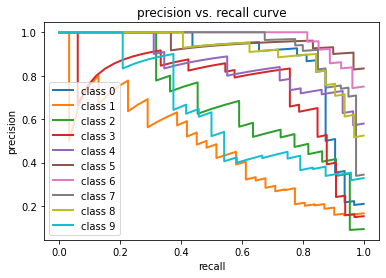

In [36]:

# precision recall curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()


0: "hiphop", 1: "blues", 2: "rock", 3: "jazz", 4: "disco", 5: "metal", 6:"classical", 7: "pop", 8: "country", 9: "reggae"

The precision recall curves vary quite a lot between different genres. For Metal and Classical music Precision stays very high as the threshold is lowered and Recall is increasing. On the other hand for Reaggea, Blues and Rock Precision quickly deteriorates with decreasing threshold. This means that with deacreasing threshold more Genres get a false positive rating, thus the model cant differntiate between the corresponding genre and other genres anymore. For the Genre Blues probably many Rock Segements got falsely classified as Blues (see the confusion matrix above). Maybe some genres can better be separated by rythmic features rather than timbre while for other Genres like Metal music timbre features work very well.

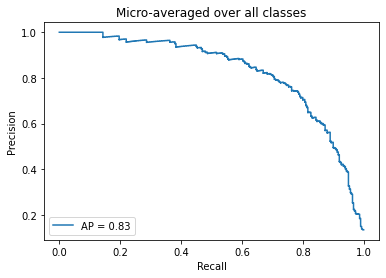

In [37]:
from sklearn.metrics import PrecisionRecallDisplay

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")


display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")


In this plot Precision and Recall are averaged across all classes.

AP = Average Precision
AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight.

Overall the model seems to predict musical genres in the GTZAN dataset quite well. The average precision is 83%, i.e. on average 83% of positive prediction for a paricular class are correct.

### Plot ROC curves for the multiclass problem

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

#### ROC Curves

TPR: TP/(TP + FN) The proportion of positive predictions on all actual positives.  
FPR: FP/(FP + TN) The proportion of poisitve predictions on all actual negatives.  

https://de.wikipedia.org/wiki/ROC-Kurve#/media/Datei:ROC_curves.svg

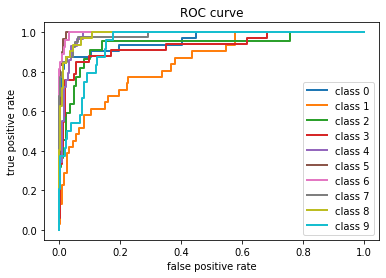

In [38]:
from sklearn.metrics import auc

# roc curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i],
                                  y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

0: "hiphop", 1: "blues", 2: "rock", 3: "jazz", 4: "disco", 5: "metal", 6:"classical", 7: "pop", 8: "country", 9: "reggae"

THe ROC Curves show a similar performance pattern as the Precision Recall plot for all classes. Reggea, Blues and Jazz semm camparatively harder do discriminate form the other genres, whereas Classical, Metal and Pop increase in TPR very fast. However all ROC curves lie far above the diagonal, suggesting a very good discriminability between genres based on timbre information (mfcc's).

## Comparing average Precision Recall curves between classifiers

In [39]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import average_precision_score, PrecisionRecallDisplay
from sklearn.preprocessing import label_binarize

n_classes = 10

Y_train = label_binarize(y_train, classes=[*range(n_classes)])
Y_test = label_binarize(y_test, classes=[*range(n_classes)])

# Creating One vs Rest Classifier 

# We already fitted the MLP OvR classifier above (clf = clf_mlp)

#Poly SVM

clf_poly = OneVsRestClassifier(svm.SVC(C=10, kernel = 'poly'))

clf_poly.fit(X_train, Y_train)

y_score_poly = clf_poly.decision_function(X_test)


#Rbf SVM

clf_rbf = OneVsRestClassifier(svm.SVC(C=10, kernel = 'rbf'))

clf_rbf.fit(X_train, Y_train)

y_score_rbf = clf_rbf.decision_function(X_test)


#Linear SVM

clf_linear = OneVsRestClassifier(svm.SVC(C=0.001, kernel = 'linear'))

clf_linear.fit(X_train, Y_train)

y_score_linear = clf_linear.decision_function(X_test)

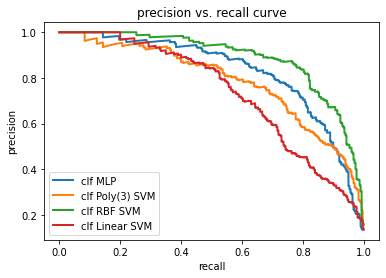

AP-MLP = 0.8282845736105969
AP-Poly = 0.7849483997945397
AP-RBF = 0.8877723263624959
AP-Linear = 0.7345388313246329


In [40]:
# Average precision recall curves of all 4 classifiers

clf_names = ["MLP", "Poly(3) SVM", "RBF SVM", "Linear SVM"]
clf_scores = [y_score, y_score_poly, y_score_rbf, y_score_linear]
precision = dict()
recall = dict()
average_precision = dict()

for i in range(4):
    # A "micro-average": quantifying score on all classes jointly
    precision["micro" + str(i)], recall["micro" + str(i)], _ = precision_recall_curve(Y_test.ravel(), clf_scores[i].ravel())
    
    average_precision["micro" + str(i)] = average_precision_score(Y_test, clf_scores[i], average="micro")

    plt.plot(recall["micro" + str(i)], precision["micro" + str(i)], lw=2, label='clf {}'.format(clf_names[i]))


plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

print("AP-MLP = " + str(average_precision["micro" + str(0)]))
print("AP-Poly = " + str(average_precision["micro" + str(1)]))
print("AP-RBF = " + str(average_precision["micro" + str(2)]))
print("AP-Linear = " + str(average_precision["micro" + str(3)]))

## Performance on test set:

### Micro averaged Precision Recall Curves

Highest Average Precision is obtained by the SVM with the RBF kernel, followed by the MLP. Both models are very expressive and thus its not surprising that they outperform the other models. 
However the SVM clearly outperforms the MLP in time used for optimization. For the MLP one hidden layer was used, where the number of nodes (850) is the average between input and ouput layer (see https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw).
Thus there are over 1 million parameters (1445860) for the MLP. For the SVM on the other hand we minimize over alpha with n dimensions (see above). Thus we only need to find n = 699 parameters. Therefore kernalized SVM leverages the fact that n << d in our dataset.

Comparing the linear and the polynomial kernel (degree 3) for the SVM, the poly-kernel outperforms the linear kernel according to the AP scores. Considering the PR plot, the linear kernel model outperforms the ploy kernel up to a certain threshold with Recall = 50%. After that intersection point Precision drops faster for the linear kernel than the poly kernel. Depending on your requirements on Precison and recall one might prefer one model over the other. 

All three models perform quite well on the genre classification task, way better than a 0 information baseline model and in the range of the accuray of classification by humans. The SVM with the RBF kernel seems to have the best performance on the test set. The RBF kernel is the most exprexssive kernel and has radial similarity contour lines, which might be of advantage for the this task. Although a Neural network is a very expressice model it does not perform as well as the SVM. With 700 data points for training we have a rather small data set, considering the number paramaters in the MLP. To leverage the expressivenes of the MLP one might need to use more data to train the model. In this example I used only a subset of the GTZAN dataset. It would be interesting to compare performance measures when using the whole data set.

Overall its surprising that genres can be seperated so well based only on timbral information of the soundfiles. 